In [1]:
import sys
sys.path.append('../')

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.weight_sharing import *
from utils.pso import PSOController, Particle
from utils.plot import *
from utils.fitness_controller import FitnessController

In [3]:
# net train settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = 'cpu'
EPOCHS = 100

# net save settings
NET_PATH = '../models/lenet/saves/lenet_tanh.save'
NET_TYPE = 'tanh'

# pso iter count
NUM_ITERATIONS = 10 #20
NUM_PARTICLES = 10 #20

# pso search settings
FOCUS_SEARCH_SPACE = [range(10) for _ in range(5)]
PARTICLE_MAX_VELOCITY = [2 for _ in range(5)]
INERTIA = 0.8

# pso save settings
SAVE_PSO_FILE = '../results/test_PSO_save.csv'
SAVE_EVERY = 1

# bh settings
BH_RADUIUS = 2 #None #2
BH_VEL_TRESHOLD = 2 #None #2

# target position
TARGET = [0.0, 0.0]
LOCK_TARGET = True

# WS settings
SHARE_ORDER = [0, 1, 2, 3, 4]
RETRAIN_AMOUNT = None #[0, 0, 0, 0, 0]
PREC_REDUCT = None #['f4', 'f4', 'f4', 'f4', 'f4']
FIXED_SPREAD = [2, 2, 2, 2, 2]
SHARE_CLUSTERS = [15, 15, 6, 2, 2]

In [4]:
dataset = MnistDataset(BATCH_SIZE, '../data', val_split=0.5)
model = LeNet5(N_CLASSES, 'tanh')
criterion = nn.CrossEntropyLoss()

lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)
ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


In [5]:
optimizer = lam_opt(model)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)
ws_controller.set_reset()

In [6]:
def fitness_vals_fc(individual:Particle):
    # reset the net
    ws_controller.reset()
    
    # share weigts by particle
    if individual.data is None:
        individual.data = ws_controller.share(SHARE_CLUSTERS, SHARE_ORDER, RETRAIN_AMOUNT, PREC_REDUCT, individual.position, FIXED_SPREAD)
    
    return [individual.data['accuracy']]

def fit_from_vals(data, targ_vals):

    return data['accuracy']

In [7]:
data = {
    'position': [],
    'accuracy': [],
    'time': [],
}

data_types = {
    'accuracy': 'float32',
    'time': 'uint8',
}

pso_data = pd.read_csv(SAVE_PSO_FILE).astype(data_types) if os.path.exists(SAVE_PSO_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(pso_cont:PSOController):
    global pso_data

    new_data = copy.deepcopy(data)

    for particle in pso_cont.swarm:

        new_data['time'].append(pso_cont.time)
        new_data['position'].append(particle.position)
        new_data['accuracy'].append(particle.data['accuracy'])

    # saving progress
    pso_data = pso_data.append(pd.DataFrame(new_data).astype(data_types))
    if pso_cont.time % SAVE_EVERY == SAVE_EVERY - 1:
        pso_data.reset_index(drop=True, inplace=True)
        os.makedirs(os.path.dirname(SAVE_PSO_FILE), exist_ok=True)
        pso_data.to_csv(SAVE_PSO_FILE, index=False)

In [8]:
fit_controll = FitnessController(TARGET, fitness_vals_fc, fit_from_vals,target_max_offset=1, lock=LOCK_TARGET)
pso = PSOController(NUM_PARTICLES, FOCUS_SEARCH_SPACE, PARTICLE_MAX_VELOCITY, INERTIA, fit_controll)

# baseline position with no modulation
pso.swarm[0].position = [0.0 for _ in range(5)]

pso.run(NUM_ITERATIONS, logger_fc, verbose=True)

Time 1/10 (0) best fitness 0.9826
Time 2/10 (1) best fitness 0.9826
Time 3/10 (2) best fitness 0.9836
Time 4/10 (3) best fitness 0.9836
Time 5/10 (4) best fitness 0.9836
Time 6/10 (5) best fitness 0.9836
Time 7/10 (6) best fitness 0.9836
Time 8/10 (7) best fitness 0.9836
Time 9/10 (8) best fitness 0.9836
Time 10/10 (9) best fitness 0.9836


[4, 4, 4, 5, 5]

In [9]:
pso_data

,position,accuracy,time
0,"[2.715936955600501, 4.179796011227187, 1.58724...",0.9824,0
1,"[4.81081446481308, 5.711731836486727, 4.231242...",0.9800,0
2,"[4.679985395715392, 3.454380918441415, 4.87296...",0.9826,0
3,"[3.594345876808292, 5.582179623660975, 3.53907...",0.9814,0
4,"[3.093598652156071, 5.610850434853599, 4.69888...",0.9792,0
...,...,...,...
95,"[5.0184131639481855, 5.544936476949287, 5.3710...",0.9808,9
96,"[2.750143520039285, 5.486752097060297, 4.77692...",0.9806,9
97,"[4.434131532669595, 3.3733184536597856, 3.0098...",0.9832,9
98,"[4.203963808450146, 5.08683937715007, 3.466810...",0.9814,9


In [13]:
pso_data[pso_data['accuracy'] == pso_data['accuracy'].max()]['position']

25    [5.0184131639481855, 5.544936476949287, 5.3710...
Name: position, dtype: object

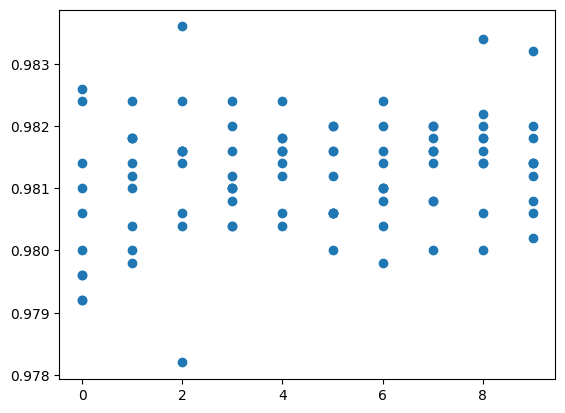

In [10]:
plt.scatter(pso_data['time'], pso_data['accuracy'])